In [1]:
#Can Run at an Acceptable Performance Network

In [1]:
import numpy as np
import math
import scipy
import scipy.signal
from random import uniform
import matplotlib.pyplot as plt

import time



In [2]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)
validation_data = list(validation_data)

In [24]:
validation_data[0]

(array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [3]:
class WrongShapeError(Exception):
    pass

class NotALayer(Exception):
    pass

class ConvolutionMustHaveOddSize(Exception):
    pass

class CrapBroke(Exception):
    pass


In [4]:
class Activation:
    def __init__(self, activationFn, activationFnPrime):
        self.activationFn = activationFn
        self.activationFnPrime = activationFnPrime
        

        
def Sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)


def SigmoidPrime(x):
    x = np.reshape(x, -1)
    return(np.diag((Sigmoid(x)*(1-Sigmoid(x)))))

def Softmax(x):
    stabilityShift = max(x)
    return(np.exp(x-stabilityShift)/sum(np.exp(x-stabilityShift)))

def SoftmaxPrime(x):    
    x = np.reshape(x, -1)
    diag = np.diag(Softmax(x))
    mat =  np.outer(Softmax(x), Softmax(x))
    return(diag - mat)

def ReLu(x):
    return(np.maximum(x, 0))

def ReLuPrime(x):
    return (np.where(x > 0, 1, 0))


def NoAct(x):
    return(x)
    
def NoActPrime(x):
    return(1)


activationDictionary = {
    'NoAct'   : Activation(NoAct, NoActPrime),
    'ReLU'    : Activation(ReLu, ReLuPrime),
    'Sigmoid' : Activation(Sigmoid, SigmoidPrime),
    'Softmax' : Activation(Softmax, SoftmaxPrime)
}

In [5]:
class LossFunction():
        def __init__(self, LossFn, LossFnPrime):
            self.LossFn = LossFn
            self.LossFnPrime = LossFnPrime

def Quadratic(predicted, expected):
    return(0.5*np.sum((expected-predicted)**2))

def QuadraticPrime(predicted, expected):
    return(predicted-expected)

def CrossEntropy(predicted, expected):
    epsilon = 1e-7  
    return(-np.sum(expected * np.log(predicted+epsilon) + (1-expected) * np.log(1-predicted+epsilon) ))

def CrossEntropyPrime(predicted, expected):
    epsilon = 1e-7 
    return(-expected/(predicted + epsilon) + (1 - expected)/(1 - predicted + epsilon))

LossDictionary = {
    'Quadratic' : LossFunction(Quadratic, QuadraticPrime),
    'Cross Entropy' : LossFunction(CrossEntropy, CrossEntropyPrime)
}

Here are the classes for the layers

In [6]:
class Layer():
    pass


In [17]:
#Create the basic layer - if there is no previous value just set up as random
class DenseLayer(Layer):
    def __init__(self, sizeIn, sizeOut, activation = 'Sigmoid', weight=None, bias=None ):
        
        if weight is None:
            weight = np.random.random((sizeOut, sizeIn))-0.5
        if bias is None:
            bias = np.random.random((sizeOut, 1))-0.5
        
        
        #Check if the data is an nxn matrix
        shapeWeight = np.shape(weight)
        shapeBias = np.shape(bias)
        
        if shapeWeight != (sizeOut, sizeIn):
            raise WrongShapeError("Error: shape of weight is incorrect")
        if shapeBias != (sizeOut, 1):
            raise WrongShapeError("Error: shape of bias is incorrect")
            
        self.weight= weight
        self.bias = bias
        self.shapeWeight = shapeWeight
        self.shapeBias = shapeBias
        self.activationFn = activationDictionary[activation].activationFn
        self.activationFnPrime = activationDictionary[activation].activationFnPrime
    
    def UpdateWeight(self, newWeight):

        shapeWeight = np.shape(newWeight)
        if shapeWeight != self.shapeWeight:
            raise WrongShapeError("Error: shape of weight is incorrect")
            
        self.weight = newWeight
        
    def UpdateBias(self, newBias):
        
        shapeBias = np.shape(newBias)
        if shapeBias != self.shapeBias:
            raise WrongShapeError("Error: shape of bias is incorrect")
            
        self.bias = newBias
        
    def ForwardOperation(self, activation):
        z = self.weight @ activation + self.bias

        return(z, self.activationFn(z))
        
        

                    
    def BackwardOperation(self, dL_dz, zThisLayer, activationPreviousLayer):
        #start = time.time()
        #This dz refers to next layer 
        dL_dz = self.activationFnPrime(zThisLayer) @  dL_dz
        #Now dz refers to this layer 
        weightError = dL_dz @ activationPreviousLayer.transpose()
        biasError = dL_dz
        #end = time.time()
        #print("BP in Dens: " + str(end-start ))
        return(self.weight.transpose()  @ dL_dz, weightError, biasError)
        
        
   

In [8]:
class FlattenLayer(Layer):
    def __init__(self):
        self.in_shape = None
        self.out_shape = None
        self.weight = None
        self.bias = None
        self.activationFn = activationDictionary['NoAct'].activationFn
        self.activationFnPrime = activationDictionary['NoAct'].activationFnPrime
    
    
    def UpdateWeight(self, newWeight):
        if newWeight is not None:
            print('Dubious')
        pass
        
    def UpdateBias(self, newBias):
        if newBias is not None:
            print('Dubious')
        pass
            

    def ForwardOperation(self, activation):
        # Store the input shape
        self.in_shape = np.shape(activation)
        # Flatten the input tensor along all its dimensions
        self.out_shape = (np.prod(self.in_shape),1)
        
        return(activation.reshape(self.out_shape), activation.reshape(self.out_shape))       

    

    
    def BackwardOperation(self, dL_dz, zThisLayer, activationPreviousLayer):
        # Reshape the derivative of the loss w.r.t. the output
        # to match the shape of the flattened input tensor
        
        return(dL_dz.reshape(self.in_shape), None, None)

        #return(dL_dz, weightError, biasError)
    
    #dL_dz, self.NNLayers[-i+1], zList[-i], activationList[-i-1]
    


Here are is the network class

In [9]:
#Create the neural net by feeding into the net a series of layers
class NeuralNet:
    def __init__(self, *layers, lossFunction='Quadratic'):
        
        #Check if NN is made of layers only
        for layer in layers:                 
            if not issubclass(type(layer), Layer):
                raise NotALayer("Error: passing something other than a layer into neural net")
                
        self.NNLayers = layers
        self.LossFunction = LossDictionary[lossFunction].LossFn
        self.LossFunctionPrime = LossDictionary[lossFunction].LossFnPrime

        
        
        
    def Train(self, data, correctOutput, learningRate = 1):

        zList, activationList = self.RunNetworkForTraining(data) 
        list_error_bias, list_error_weight = self.CalculateErrors(zList, activationList, correctOutput)
        self.UpdateWeightsOfNetwork(list_error_bias, list_error_weight, learningRate)
        
        return(activationList[-1], self.LossFunction(activationList[-1], correctOutput))
    
    
    def RunNetworkForTraining(self, activation):
        
        activationList =[activation]
        zList = []
        
        for layer in self.NNLayers: 
            z, activation = layer.ForwardOperation(activation)
            
            activationList.append(activation)
            zList.append(z)
        return(zList, activationList)    
        
    
    def UpdateWeightsOfNetwork(self, list_error_bias, list_error_weight, learningRate):
        
        for layer, error_bias, error_weight in zip(self.NNLayers, list_error_bias[::-1], list_error_weight[::-1]): 
            if type(layer) == FlattenLayer or  type(layer) == MaxPoolLayer :
                continue
                
            elif type(layer) == ConvolutionLayer:
                layer.UpdateWeight(layer.weight - learningRate * error_weight)
                #layer.UpdateBias(layer.bias - learningRate * error_bias)
                
            else:
                layer.UpdateWeight(layer.weight - learningRate * error_weight)
                layer.UpdateBias(layer.bias - learningRate * error_bias)

        
        
    def CalculateErrors(self, zList, activationList, correctOutput):
        #Start by calculating the errors on the output

        start = time.time()


        
        dLoss_dFinalAct = self.LossFunctionPrime(activationList[-1], correctOutput)
        dL_dz = self.NNLayers[-1].activationFnPrime(zList[-1]).transpose() @ dLoss_dFinalAct  ##Fairly sure this only works for dense

        weightError = dL_dz @ activationList[-2].transpose()
        biasError = dL_dz

        list_error_bias   = [biasError]
        list_error_weight = [weightError ]
        
        #This is actually dL_da of the input to the last layer
        dL_dz = self.NNLayers[-1].weight.transpose()  @ dL_dz
        
        
        
        #Backpropagate
        for i in range(2, len(self.NNLayers)+1): #Go through each layer in the NN 
            
            dL_dz, weightError, biasError = self.NNLayers[-i].BackwardOperation(dL_dz, zList[-i], activationList[-i-1])
       
            list_error_bias.append(biasError) 
            list_error_weight.append(weightError)
            
        return(list_error_bias, list_error_weight)
    
    
    def Run(self, activation, expected=None):
        
        for layer in self.NNLayers: 
            z, activation = layer.ForwardOperation(activation)
            
        if expected is not None:
            return(activation, self.LossFunction(activation, expected))
    
        else:
            return(activation)
            
    
    
    

In [10]:
#z_kl = a_kl w_(k+a, l+b)
#dl/dw_ij = dl/dz_kl dz_kl/dw_ij
#         = a_kl kron_(k+a, i) kron_(l+b, j) dl/dz_kl
#dl/dw_(k+a, l+b) = a_kl * dl/dz_kl

In [11]:
class MaxPoolLayer(Layer):
    def __init__(self, pool_size, stride):
        self.stride = stride
        self.pool_size = pool_size
        self.cache = None
        self.weight = None
        self.bias = None
        self.activationFn = activationDictionary['NoAct'].activationFn
        self.activationFnPrime = activationDictionary['NoAct'].activationFnPrime
        
        
    def UpdateWeight(self, newWeight):
        if newWeight is not None:
            print('Dubious')
        pass
        
    def UpdateBias(self, newBias):
        if newBias is not None:
            print('Dubious')
        pass
    
    
    def ForwardOperation(self, activation):
        nFilters, height, width = activation.shape
        poolHeight, poolWidth = self.pool_size
        outHeight = height // poolHeight
        outWidth = width // poolWidth
        activationOut = np.zeros((nFilters, outHeight, outWidth))
        
        self.cache = ( nFilters, outHeight, outWidth, poolHeight, poolWidth)
        
        
        for k in range(0, nFilters):
            for i in range(0, outHeight):
                for j in range(0, outWidth):
                    activationOut[k, i, j] = np.max(activation[k, i*poolHeight:(i+1)*poolHeight, j*poolWidth:(j+1)*poolWidth])
        
        
        return(activationOut, activationOut)
    
    
    def BackwardOperation(self, dL_dz, zThisLayer, activationPreviousLayer):
        start = time.time()
        nFilters, outHeight, outWidth, poolHeight, poolWidth = self.cache
        
        dL_dzAll = []
        for k in range(nFilters):
            zThisFilter = zThisLayer[k,:,:]
            
            dL_dz_k = dL_dz[k,:,:]
            dL_dz_k = self.activationFnPrime(zThisFilter) * dL_dz_k
        
            dL_dzK = np.zeros_like(activationPreviousLayer[k])
            for i in range(outHeight):
                for j in range(outWidth):
                
                    actInPool = activationPreviousLayer[ k, i*poolHeight:(i+1)*poolHeight, j*poolWidth:(j+1)*poolWidth]
                   
                    maxActInPool = np.max(actInPool, keepdims=True)
                
                    doutPool = dL_dz_k[i, j]
                    mask = (actInPool == maxActInPool)
                    dL_dzK[i*poolHeight:(i+1)*poolHeight, j*poolWidth:(j+1)*poolWidth] += doutPool * mask
            
            dL_dzAll.append(dL_dzK)
        end = time.time()
        print("BP in Pool: " +str(start-end))
        return(np.array(dL_dzAll), None, None)


In [12]:
class ConvolutionLayer(Layer):
    
    def __init__(self, nFilters, kernel_size, sizeImage, activation = 'ReLU', weight=None, bias=None ):
        
        if kernel_size%2 != 1:
            raise ConvolutionMustHaveOddSize("Error: the size of the convolution mask must be odd")
        
        if weight is None:
            

            """Xavier initialization for weights."""
            stddev = np.sqrt(2.0 / (2*kernel_size))
            weight = np.random.normal(0, stddev, (nFilters, kernel_size, kernel_size ))
            
            #weight = np.random.random((nFilters, kernel_size, kernel_size ))-0.5
        if bias is None:
            bias = np.random.random((nFilters,1,1))-0.5
        
        
        #Check if the data is an nxn matrix
        shapeWeight = np.shape(weight)
        shapeBias = np.shape(bias)
        
        if shapeWeight != (nFilters, kernel_size, kernel_size ):
            raise WrongShapeError("Error: shape of weight is incorrect")
        if shapeBias != (nFilters,1,1):
            raise WrongShapeError("Error: shape of bias is incorrect")
            
        self.nFilters = nFilters
        self.sizeImage = sizeImage
        self.weight= weight
        self.bias = bias
        self.shapeWeight = shapeWeight
        self.shapeBias = shapeBias
        self.activationFn = activationDictionary[activation].activationFn
        self.activationFnPrime = activationDictionary[activation].activationFnPrime
        
            
    def UpdateWeight(self, newWeight):

        shapeWeight = np.shape(newWeight)
        if shapeWeight != self.shapeWeight:
            raise WrongShapeError("Error: shape of weight is incorrect")
            
        self.weight = newWeight
        
    def UpdateBias(self, newBias):
        
        shapeBias = np.shape(newBias)
        print(shapeBias)
        if shapeBias != self.shapeBias:
            raise WrongShapeError("Error: shape of bias is incorrect")
            
        self.bias = newBias
        
    def ForwardOperation(self, activation):
        inShape = np.shape(activation)
        activationList = []
        zList = []
        
        shapedActivation = np.reshape(activation, self.sizeImage)
        
        for i in range(self.nFilters):

            filter_weight = self.weight[i]
            filter_bias = self.bias[i]
            
            z_i = scipy.signal.correlate(shapedActivation, filter_weight, mode='same')# + filter_bias
            zList.append(z_i)#.reshape(inShape))
            
            
            
            activation_i = self.activationFn(z_i)
            activationList.append(activation_i)#.reshape(inShape))
        
        zList =  np.asarray(zList)
        activationList = np.asarray(activationList)

        return(zList, activationList)

       

    def BackwardOperation(self, dL_dz, zThisLayer, activationPreviousLayer):

        start = time.time()
        dL_dzOut = np.zeros((self.nFilters, *self.sizeImage))
        weightError = np.zeros_like(self.weight)
        biasError = np.zeros((self.nFilters,1,1))
        shapedActivation = np.reshape(activationPreviousLayer, self.sizeImage)
        shapedActivation = np.pad(shapedActivation, ((self.shapeWeight[1]//2,self.shapeWeight[1]//2), (self.shapeWeight[1]//2,self.shapeWeight[1]//2)), constant_values = 0)
            
        for i in range(self.nFilters):
            zThisFilter = zThisLayer[i]
            
            dL_dz_i = dL_dz[i]
            filter_weight = self.weight[i]

            dL_dz_i = self.activationFnPrime(zThisFilter) @ dL_dz_i
            
            biasError_i = np.sum(dL_dz_i)
            weightError_i = scipy.signal.correlate(shapedActivation, dL_dz_i, mode = 'valid')
            dL_dz_i = scipy.signal.convolve2d(dL_dz_i, filter_weight, mode= 'same')  #may be wrong          
            

            dL_dzOut[i] = dL_dz_i
            weightError[i] = weightError_i
            biasError[i] = biasError_i
        end = time.time()
        print("BP in Conv: " +str(start-end))          
        return(dL_dzOut, weightError, biasError)

BP in Pool: -0.0062215328216552734
BP in Conv: -0.0040323734283447266
BP in Pool: -0.006648540496826172
BP in Conv: -0.004717350006103516
BP in Pool: -0.0075855255126953125
BP in Conv: -0.005048274993896484
BP in Pool: -0.01196599006652832
BP in Conv: -0.008204460144042969
BP in Pool: -0.004830598831176758
BP in Conv: -0.008020401000976562
BP in Pool: -0.011267423629760742
BP in Conv: -0.004909515380859375
BP in Pool: -0.005454063415527344
BP in Conv: -0.011332035064697266
BP in Pool: -0.007452726364135742
BP in Conv: -0.00933837890625
BP in Pool: -0.0019683837890625
BP in Conv: -0.005697727203369141
BP in Pool: -0.01720142364501953
BP in Conv: -0.004765033721923828
Epoch 0 done!


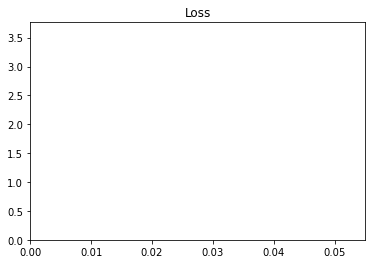

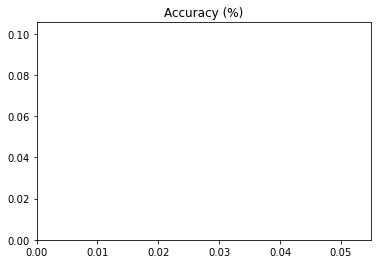

In [18]:
nfilt = 5
kerSize = 5
l1 = ConvolutionLayer(nfilt, kerSize, (28, 28), 'ReLU')
l2 = MaxPoolLayer((4,4),1)
#l3 = ConvolutionLayer(nfilt, 3, (14, 14), 'ReLU')
#l4 = MaxPoolLayer((2,2),1)
l5 = FlattenLayer()
l6 = DenseLayer(7**2*nfilt, 15, 'Sigmoid')
l7 = DenseLayer(15, 10, 'Softmax')

NN = NeuralNet(l1, l2, l5, l6, l7, lossFunction='Cross Entropy')


lossEpoch = []
accuracyEpoch = []
epoch = 1

usedFilters = []
for i in range(epoch):
    loss = []
    accuracy = 0
    for number, answer in training_data[:10]:
        
        guess, l = NN.Train(number, answer, learningRate=0.05)
        loss.append(l)
        #print(np.array([answer.T, guess.T]))
        if np.argmax(answer, axis=0)[0] == np.argmax(guess, axis=0)[0]:
            accuracy += 1
            
    #for act in convHoldActivation:
        #plt.imshow(act)
        #plt.show()
        
    print("Epoch %i done!" %i)
    accuracyEpoch.append(100*accuracy/1000)    
    lossEpoch.append(np.mean(loss))
    
    usedFilters.append(l1.weight)
    
plt.plot(lossEpoch)
plt.title("Loss")
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(accuracyEpoch)
plt.title("Accuracy (%)")
plt.xlim(0)
plt.ylim(0)
plt.show()

In [355]:
testOn = 100

accuracy = 0

for number, answer in validation_data:
    guess, l = NN.Run(number, expected=answer)
    
    #print("The neural net guesses:\n%i"%np.argmax(guess, axis=0)[0])
    #plt.imshow(number.reshape(28, 28))
    #plt.show()
    
    if answer == np.argmax(guess, axis=0)[0]:
        accuracy += 1
    

print("===========================")
print("CRAPNet was right %1.1f%% of the time!" %(accuracy/len(validation_data) * 100))

CRAPNet was right 18.4% of the time!


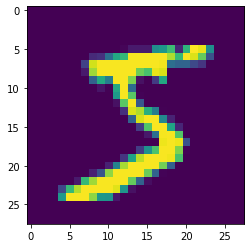

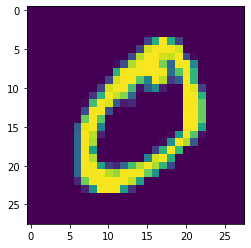

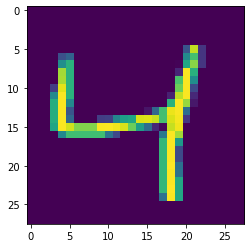

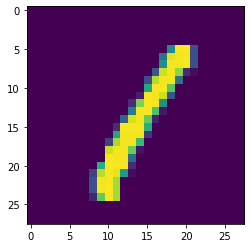

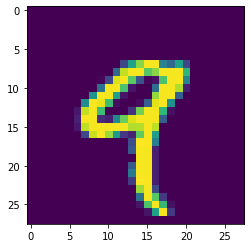

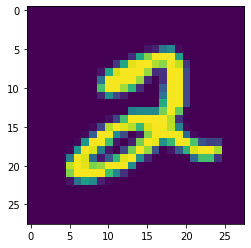

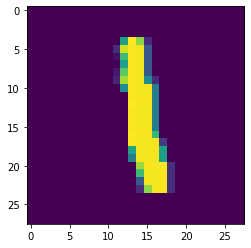

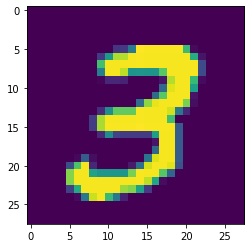

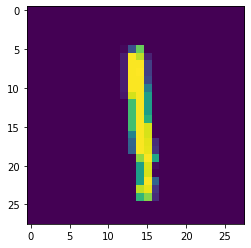

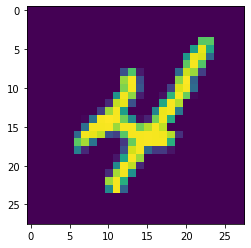

In [15]:
for number, answer in training_data[:10]:
    plt.imshow(np.reshape(number, (28,28)))
    plt.show()

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!


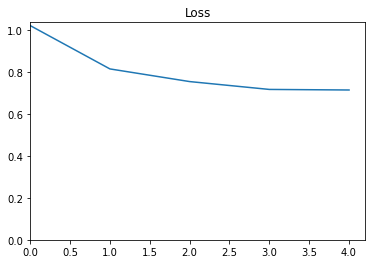

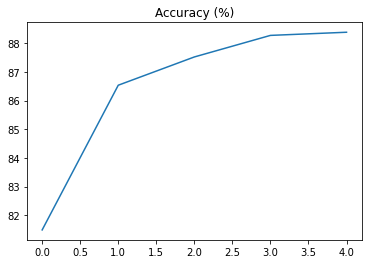

In [20]:
l1 = DenseLayer(28**2, 8, 'Sigmoid')
l2 = DenseLayer(8, 15, 'Sigmoid')
l3 = DenseLayer(15, 10, 'Softmax')
NN = NeuralNet(l1, l2, l3, lossFunction='Cross Entropy')


lossEpoch = []
accuracyEpoch = []
epoch = 5
for i in range(epoch):
    loss = []
    accuracy = 0
    j = 0
    for number, answer in training_data:
        j+=1
        guess, l = NN.Train(number, answer, learningRate=0.1)
        loss.append(l)

        if np.argmax(answer, axis=0)[0] == np.argmax(guess, axis=0)[0]:
            accuracy += 1
    
    print("Epoch %i done!" %i)
    accuracyEpoch.append(100*accuracy/(j+1))    
    lossEpoch.append(np.mean(loss))
    
plt.plot(lossEpoch)
plt.title("Loss")
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(accuracyEpoch)
plt.title("Accuracy (%)")
plt.show()

The neural net guesses:
3


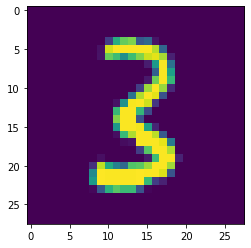

The neural net guesses:
8


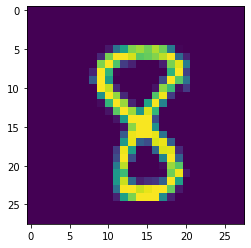

The neural net guesses:
6


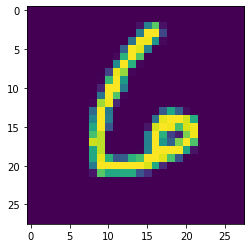

The neural net guesses:
9


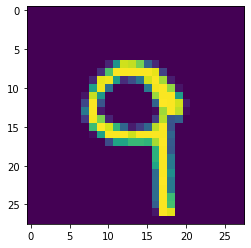

The neural net guesses:
6


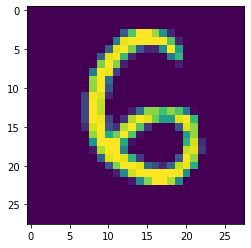

The neural net guesses:
6


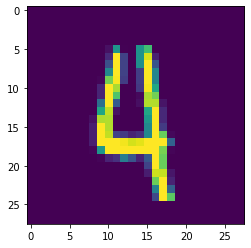

The neural net guesses:
4


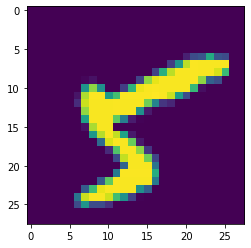

The neural net guesses:
5


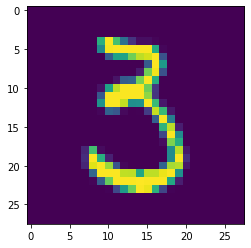

The neural net guesses:
8


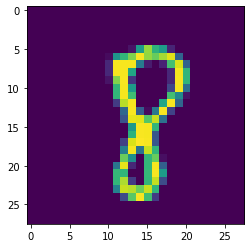

The neural net guesses:
4


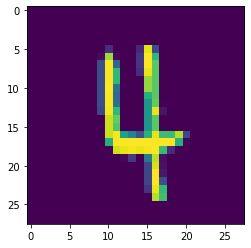

The neural net guesses:
5


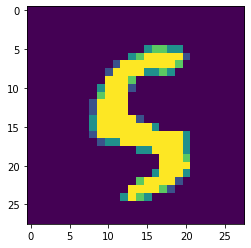

The neural net guesses:
2


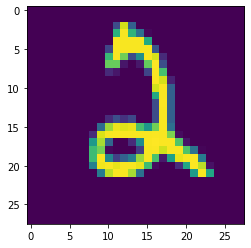

The neural net guesses:
3


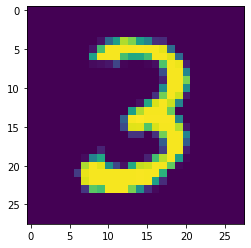

The neural net guesses:
8


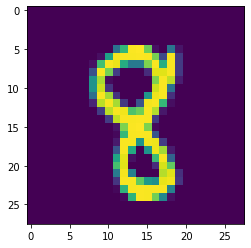

The neural net guesses:
4


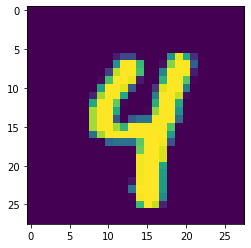

The neural net guesses:
8


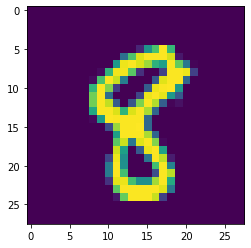

The neural net guesses:
1


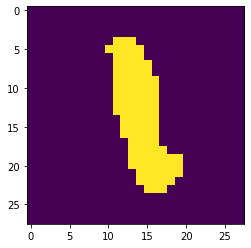

The neural net guesses:
5


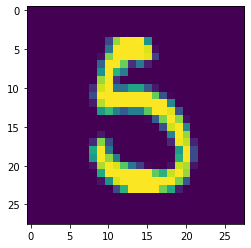

The neural net guesses:
0


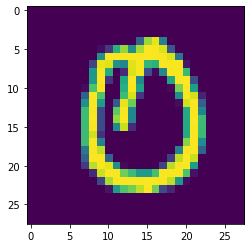

The neural net guesses:
5


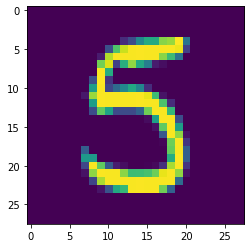

The neural net guesses:
9


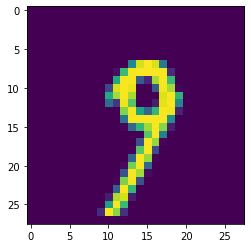

The neural net guesses:
7


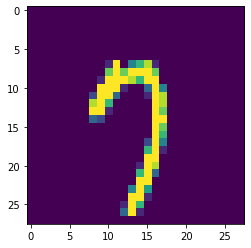

The neural net guesses:
4


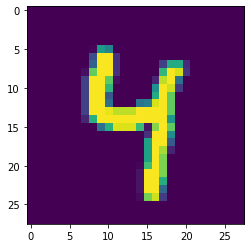

The neural net guesses:
1


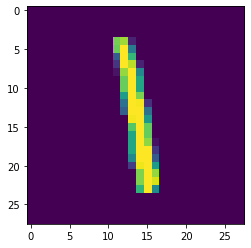

The neural net guesses:
0


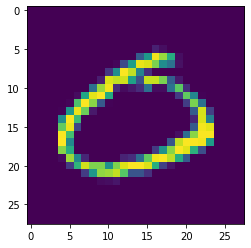

The neural net guesses:
5


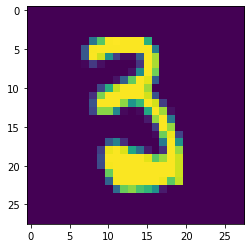

The neural net guesses:
0


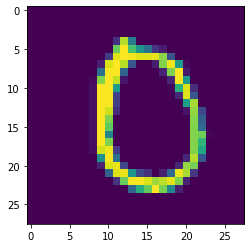

The neural net guesses:
6


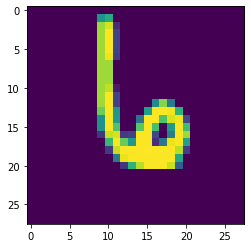

The neural net guesses:
2


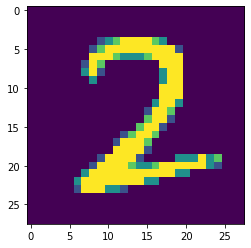

The neural net guesses:
9


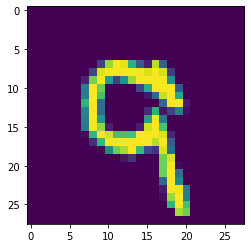

The neural net guesses:
9


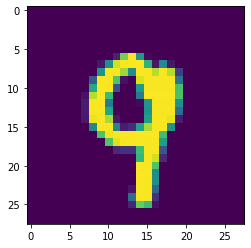

The neural net guesses:
4


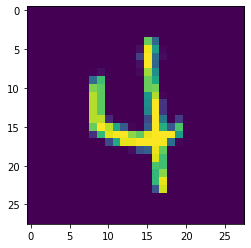

The neural net guesses:
1


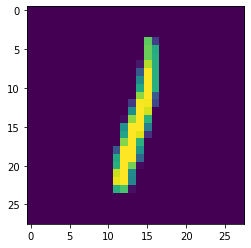

The neural net guesses:
5


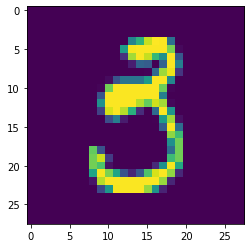

The neural net guesses:
6


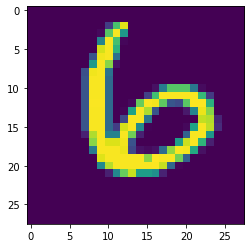

The neural net guesses:
8


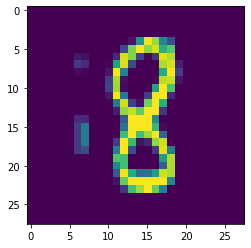

The neural net guesses:
0


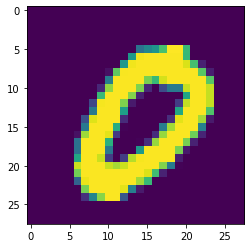

The neural net guesses:
7


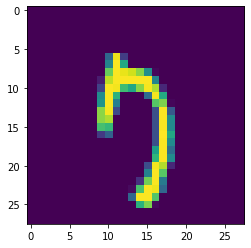

The neural net guesses:
7


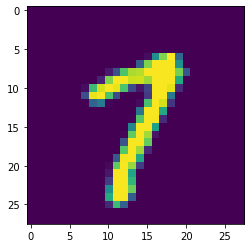

The neural net guesses:
6


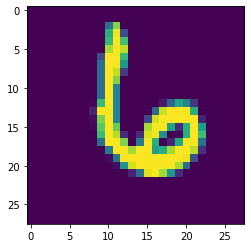

The neural net guesses:
8


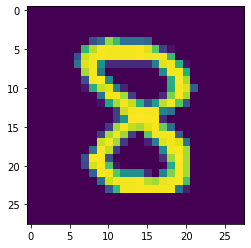

The neural net guesses:
9


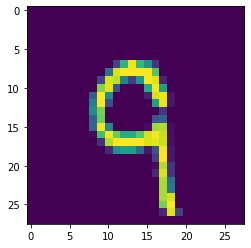

The neural net guesses:
0


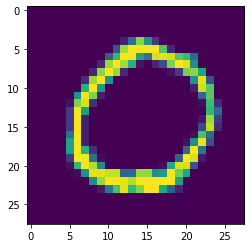

The neural net guesses:
3


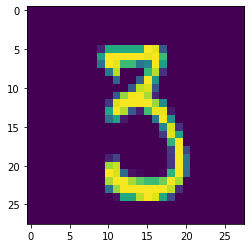

The neural net guesses:
8


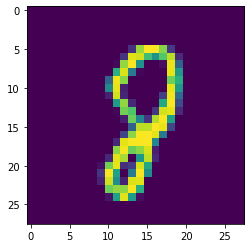

The neural net guesses:
3


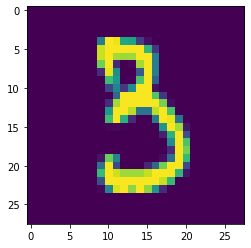

The neural net guesses:
7


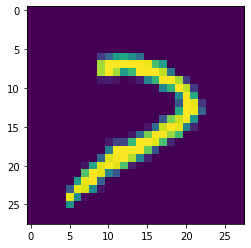

The neural net guesses:
7


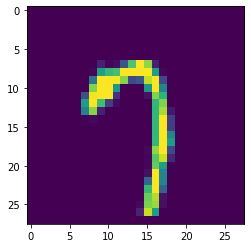

The neural net guesses:
8


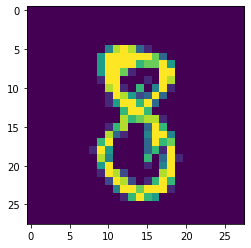

The neural net guesses:
6


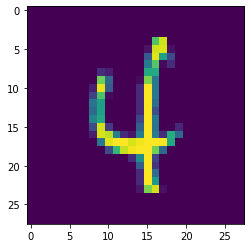

The neural net guesses:
4


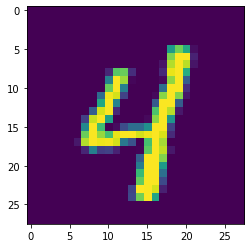

The neural net guesses:
1


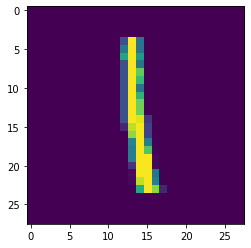

The neural net guesses:
5


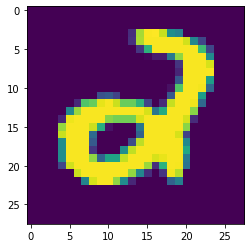

The neural net guesses:
9


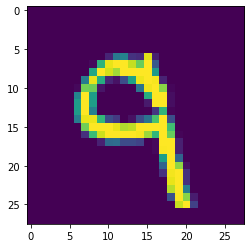

The neural net guesses:
0


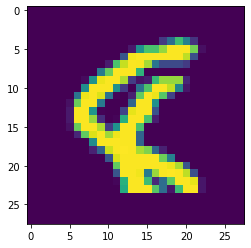

The neural net guesses:
1


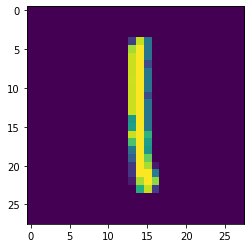

The neural net guesses:
1


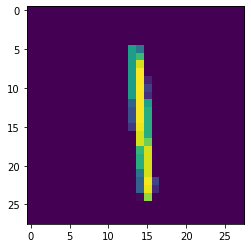

The neural net guesses:
0


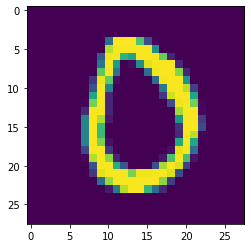

The neural net guesses:
6


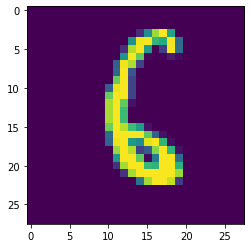

The neural net guesses:
6


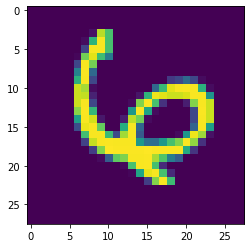

The neural net guesses:
5


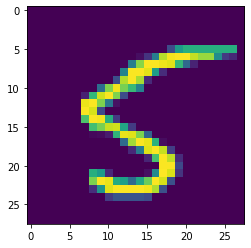

The neural net guesses:
0


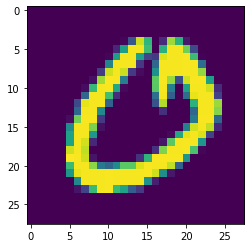

The neural net guesses:
1


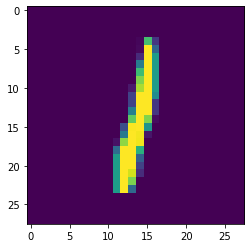

The neural net guesses:
1


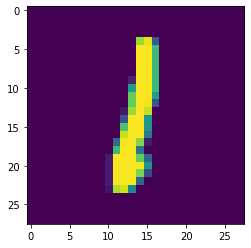

The neural net guesses:
7


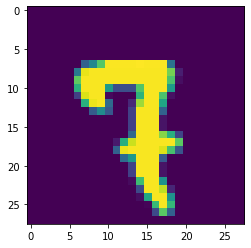

The neural net guesses:
2


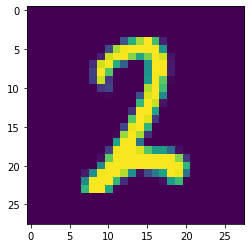

The neural net guesses:
7


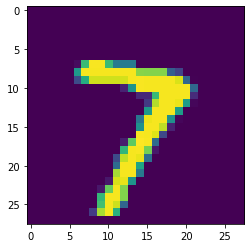

The neural net guesses:
3


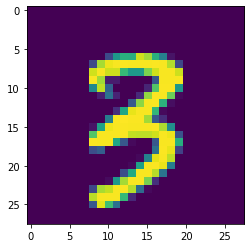

The neural net guesses:
1


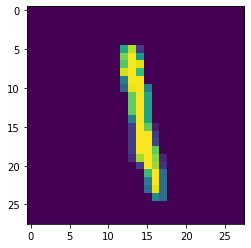

The neural net guesses:
4


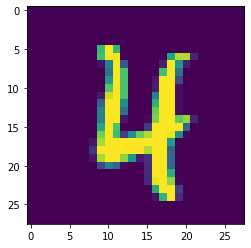

The neural net guesses:
0


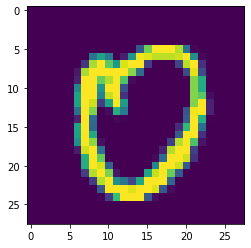

The neural net guesses:
5


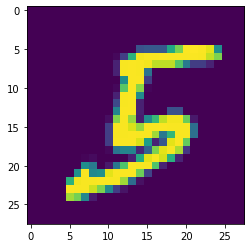

The neural net guesses:
0


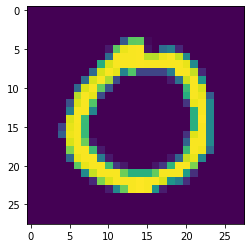

The neural net guesses:
6


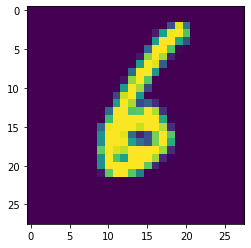

The neural net guesses:
8


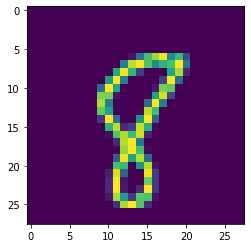

The neural net guesses:
7


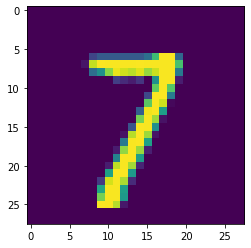

The neural net guesses:
6


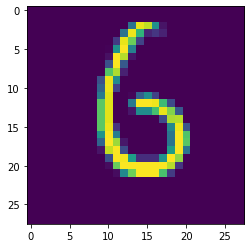

The neural net guesses:
8


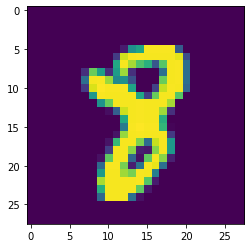

The neural net guesses:
3


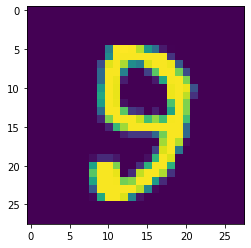

The neural net guesses:
4


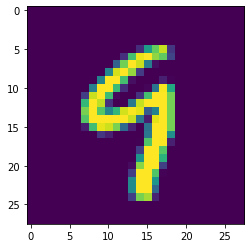

The neural net guesses:
4


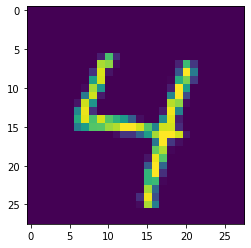

The neural net guesses:
0


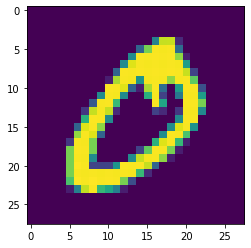

The neural net guesses:
6


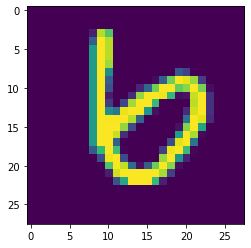

The neural net guesses:
1


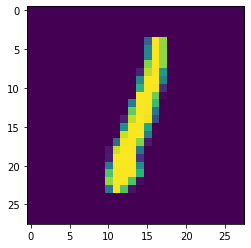

The neural net guesses:
9


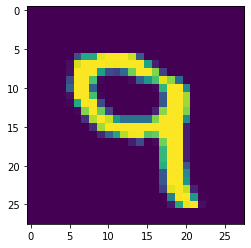

The neural net guesses:
2


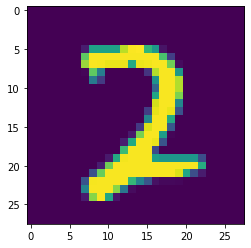

The neural net guesses:
6


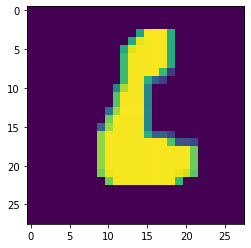

The neural net guesses:
3


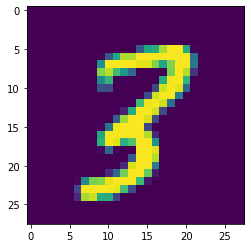

The neural net guesses:
1


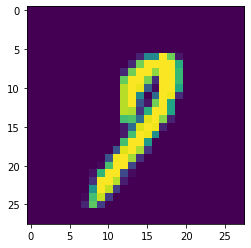

The neural net guesses:
4


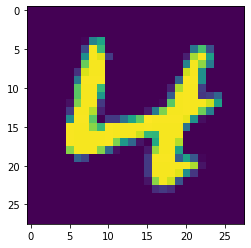

The neural net guesses:
4


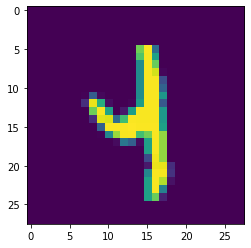

The neural net guesses:
4


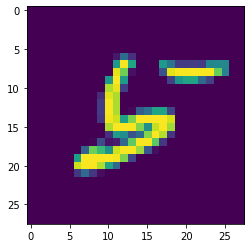

The neural net guesses:
6


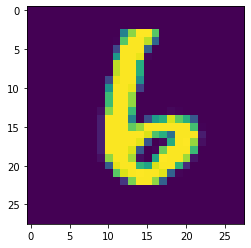

The neural net guesses:
6


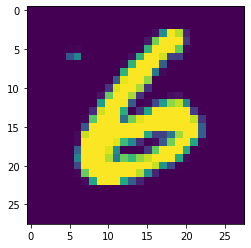

The neural net guesses:
1


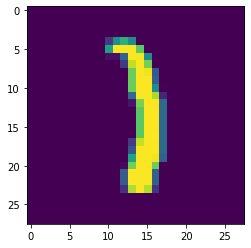

The neural net guesses:
7


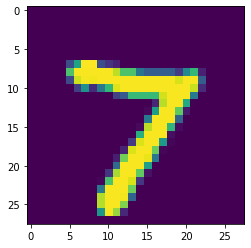

The neural net guesses:
2


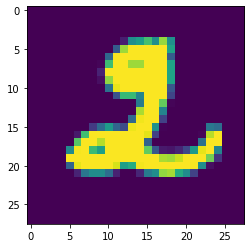

The neural net guesses:
8


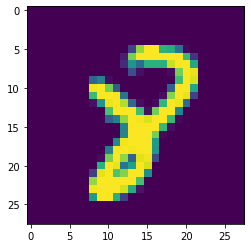

The neural net guesses:
6


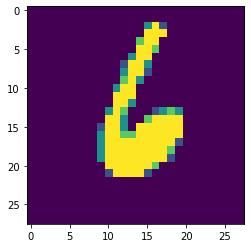

The neural net guesses:
7


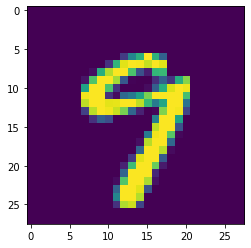

The neural net guesses:
7


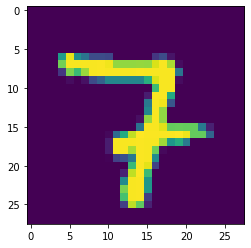

The neural net guesses:
0


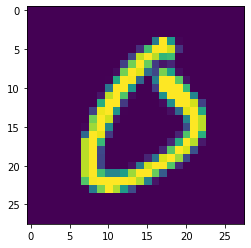

The neural net guesses:
9


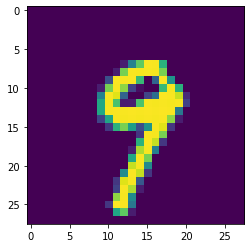

The neural net guesses:
1


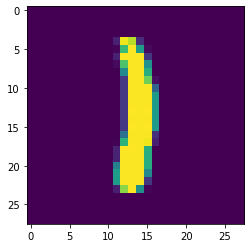

The neural net guesses:
6


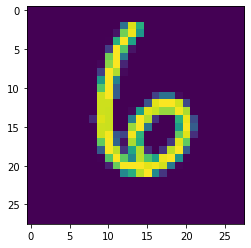

The neural net guesses:
2


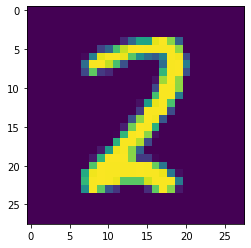

The neural net guesses:
8


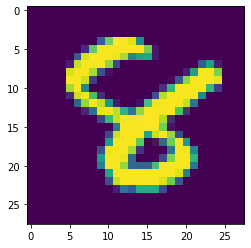

The neural net guesses:
3


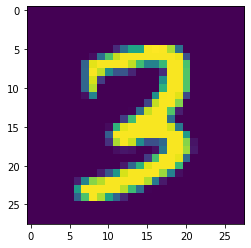

The neural net guesses:
6


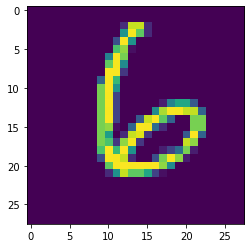

The neural net guesses:
4


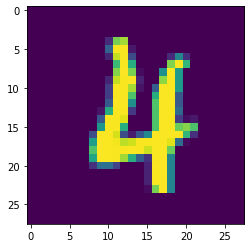

The neural net guesses:
9


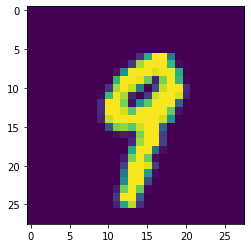

The neural net guesses:
5


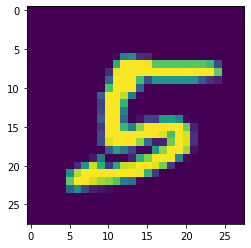

The neural net guesses:
8


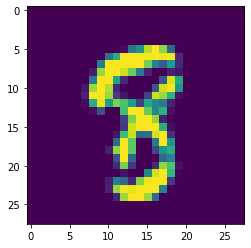

The neural net guesses:
6


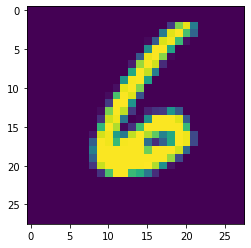

The neural net guesses:
8


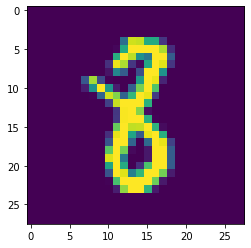

The neural net guesses:
7


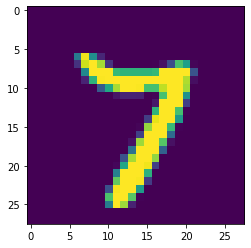

The neural net guesses:
8


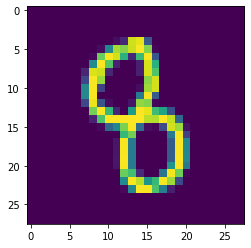

The neural net guesses:
8


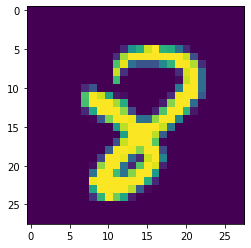

The neural net guesses:
6


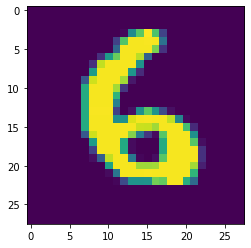

The neural net guesses:
9


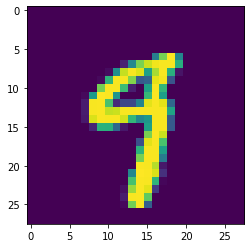

The neural net guesses:
4


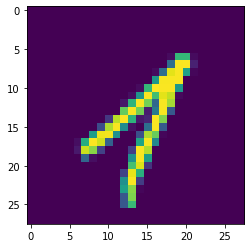

The neural net guesses:
7


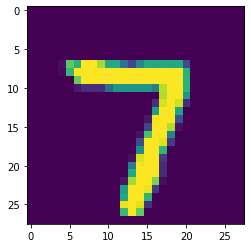

The neural net guesses:
6


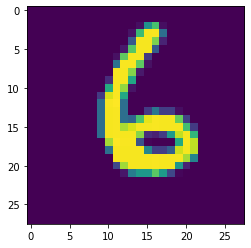

The neural net guesses:
0


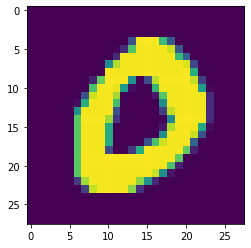

The neural net guesses:
9


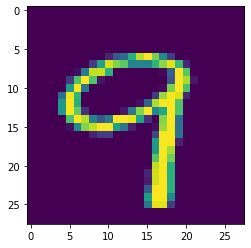

The neural net guesses:
6


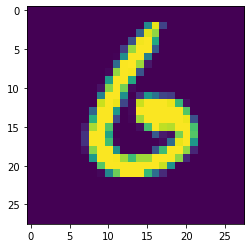

The neural net guesses:
7


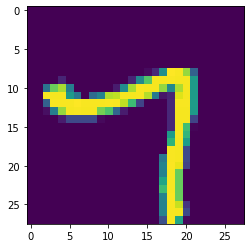

The neural net guesses:
0


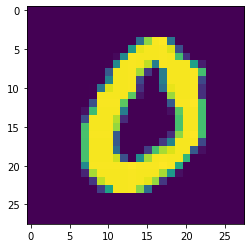

The neural net guesses:
9


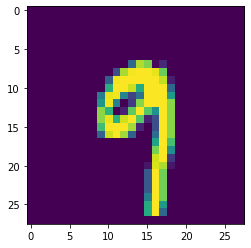

The neural net guesses:
7


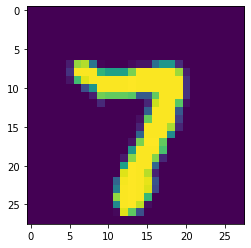

The neural net guesses:
1


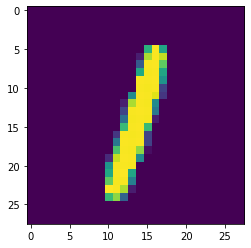

The neural net guesses:
3


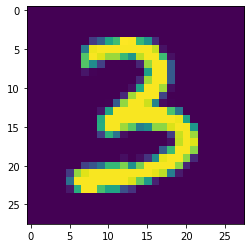

The neural net guesses:
6


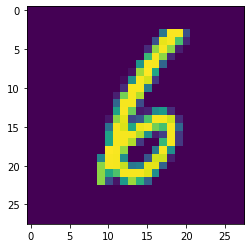

The neural net guesses:
8


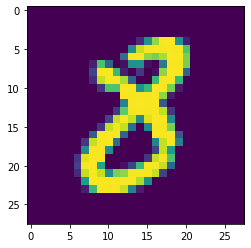

The neural net guesses:
4


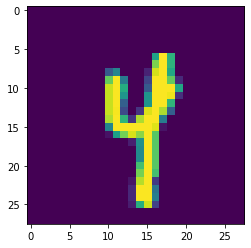

The neural net guesses:
6


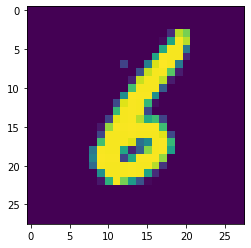

The neural net guesses:
1


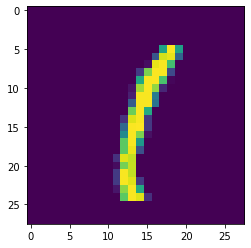

The neural net guesses:
7


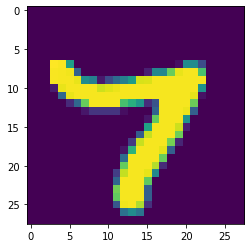

The neural net guesses:
5


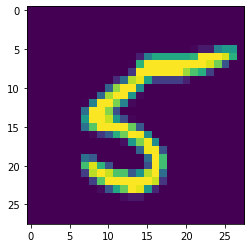

The neural net guesses:
1


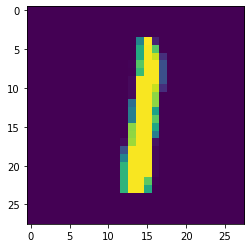

The neural net guesses:
3


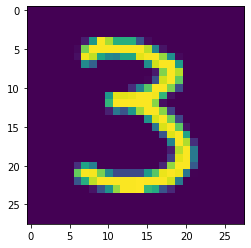

The neural net guesses:
3


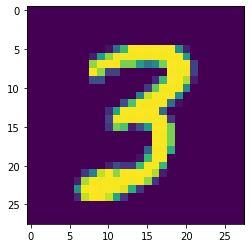

The neural net guesses:
5


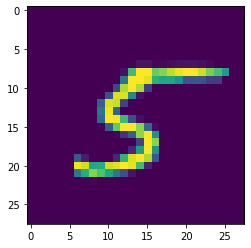

The neural net guesses:
7


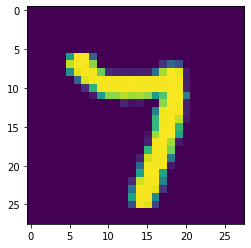

The neural net guesses:
4


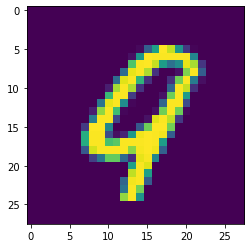

The neural net guesses:
9


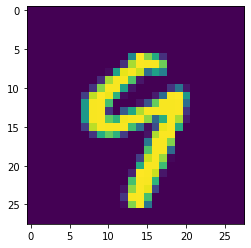

The neural net guesses:
6


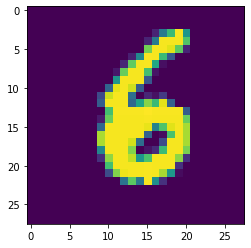

The neural net guesses:
7


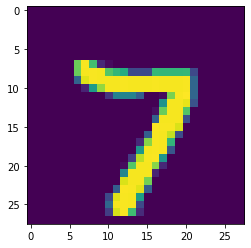

The neural net guesses:
3


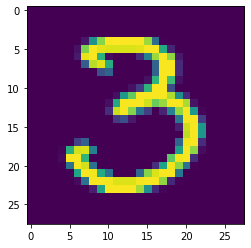

The neural net guesses:
5


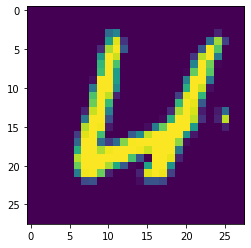

The neural net guesses:
1


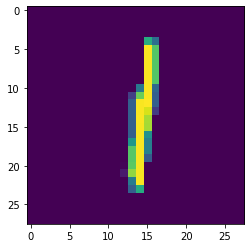

The neural net guesses:
0


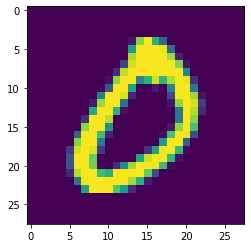

The neural net guesses:
4


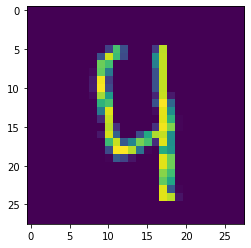

The neural net guesses:
2


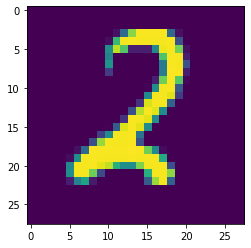

The neural net guesses:
4


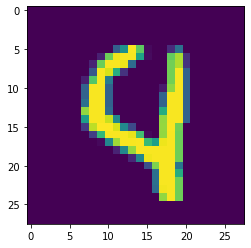

The neural net guesses:
3


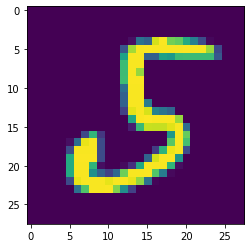

The neural net guesses:
0


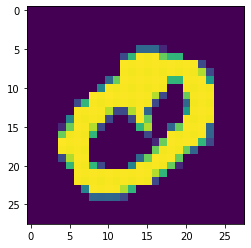

The neural net guesses:
0


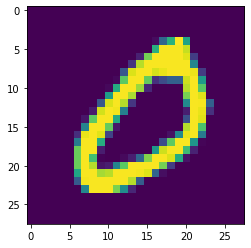

The neural net guesses:
1


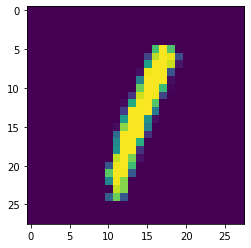

The neural net guesses:
6


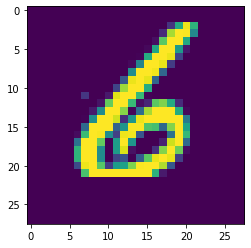

The neural net guesses:
6


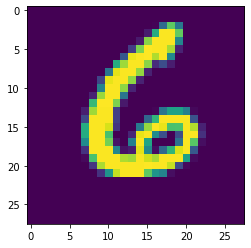

The neural net guesses:
4


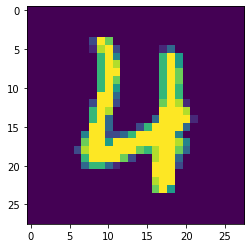

The neural net guesses:
7


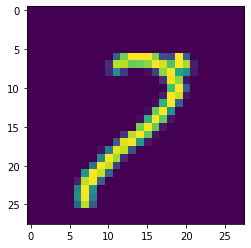

The neural net guesses:
9


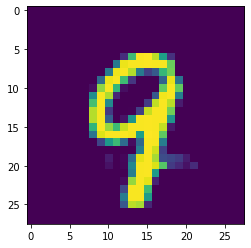

The neural net guesses:
4


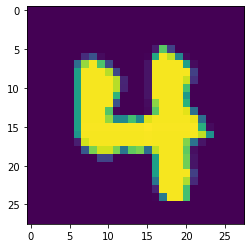

The neural net guesses:
6


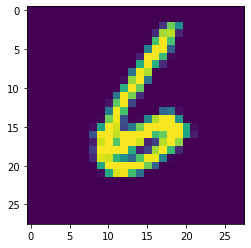

The neural net guesses:
3


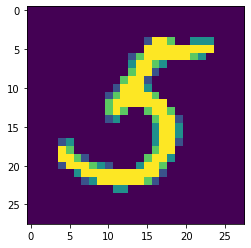

The neural net guesses:
2


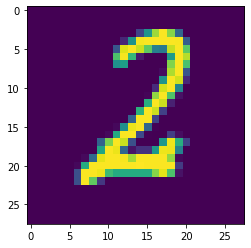

The neural net guesses:
6


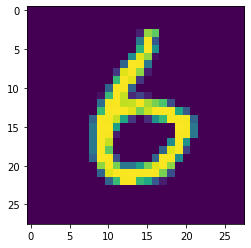

The neural net guesses:
9


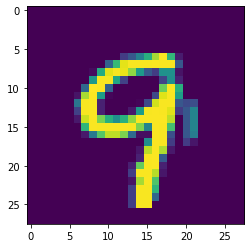

The neural net guesses:
8


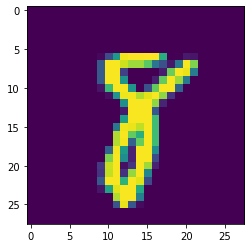

The neural net guesses:
8


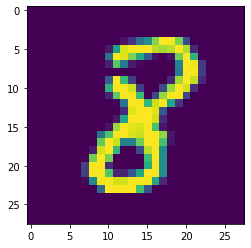

The neural net guesses:
8


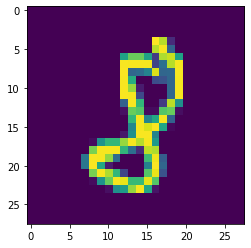

The neural net guesses:
5


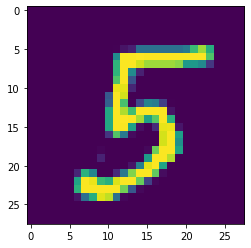

The neural net guesses:
7


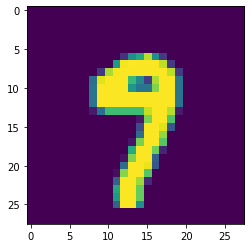

The neural net guesses:
3


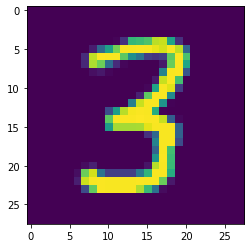

The neural net guesses:
8


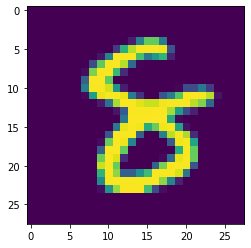

The neural net guesses:
4


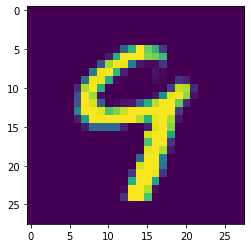

The neural net guesses:
8


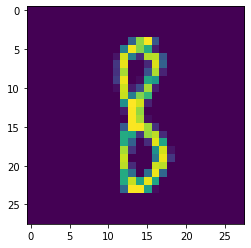

The neural net guesses:
8


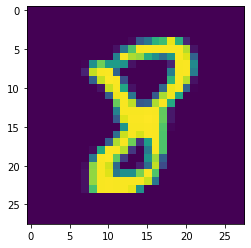

The neural net guesses:
5


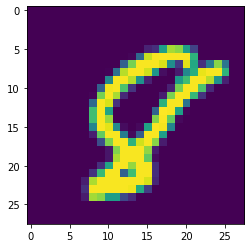

The neural net guesses:
3


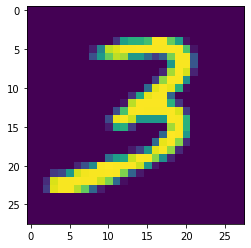

The neural net guesses:
4


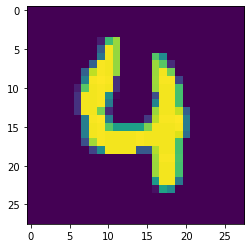

The neural net guesses:
4


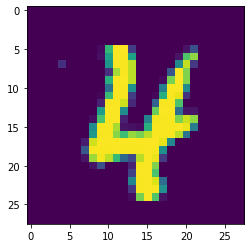

The neural net guesses:
3


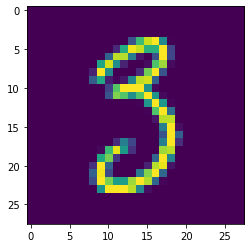

The neural net guesses:
0


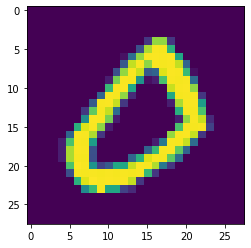

The neural net guesses:
7


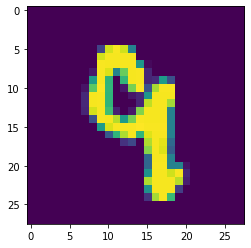

The neural net guesses:
5


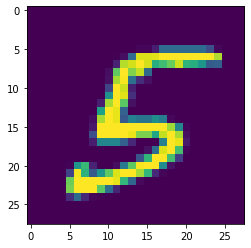

The neural net guesses:
4


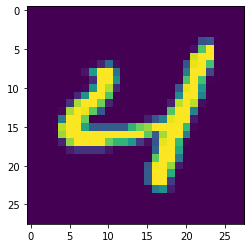

The neural net guesses:
4


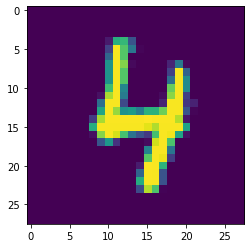

The neural net guesses:
1


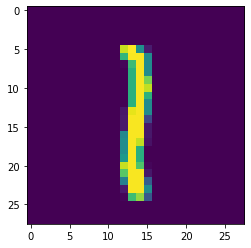

The neural net guesses:
8


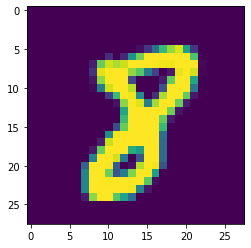

The neural net guesses:
0


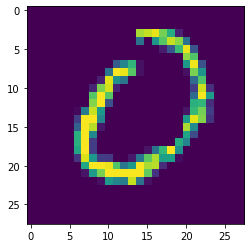

The neural net guesses:
6


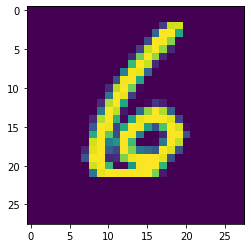

The neural net guesses:
1


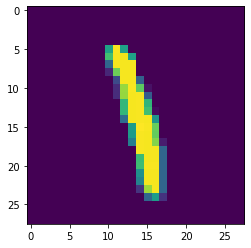

The neural net guesses:
3


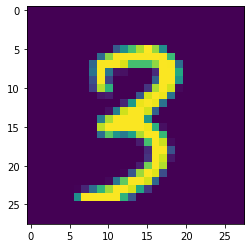

The neural net guesses:
3


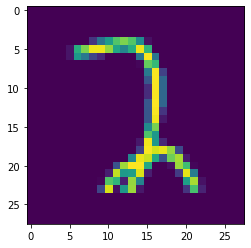

The neural net guesses:
0


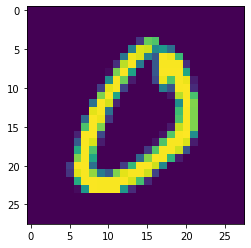

The neural net guesses:
8


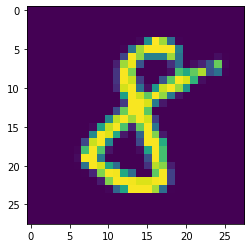

The neural net guesses:
6


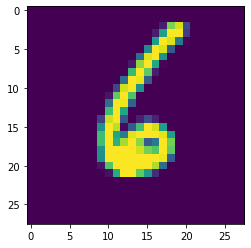

The neural net guesses:
0


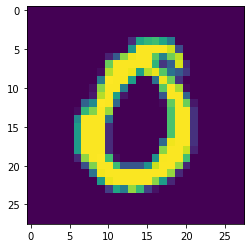

The neural net guesses:
3


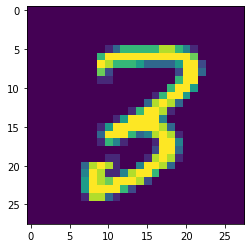

The neural net guesses:
5


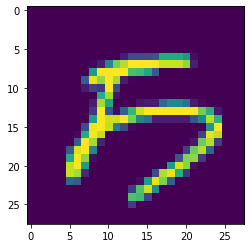

The neural net guesses:
4


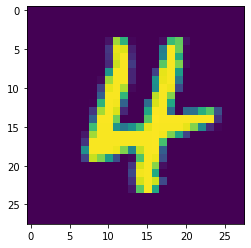

The neural net guesses:
9


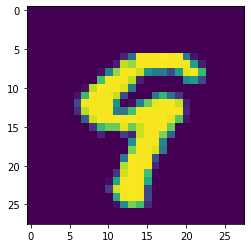

The neural net guesses:
0


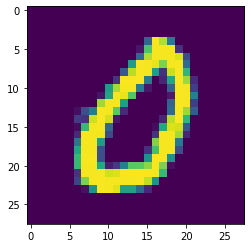

The neural net guesses:
5


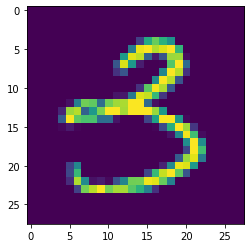

The neural net guesses:
1


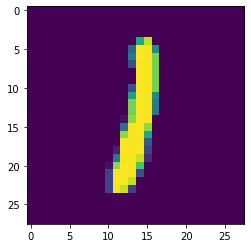

The neural net guesses:
0


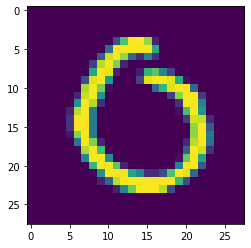

The neural net guesses:
9


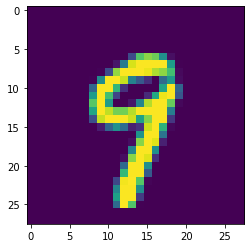

The neural net guesses:
3


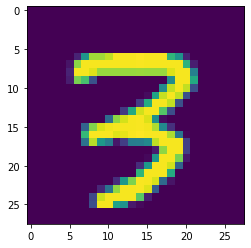

The neural net guesses:
2


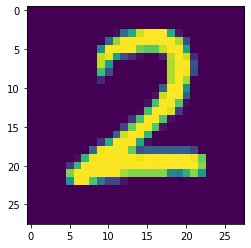

The neural net guesses:
8


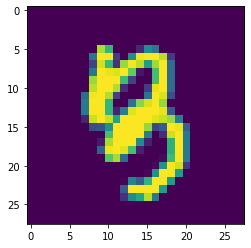

The neural net guesses:
3


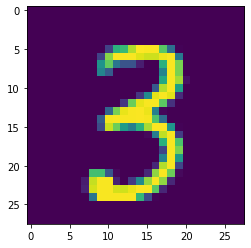

The neural net guesses:
3


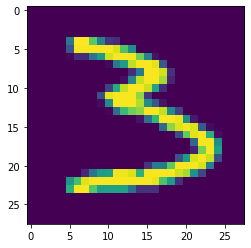

The neural net guesses:
7


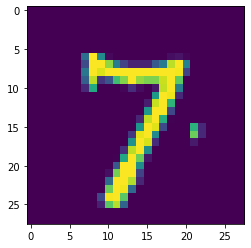

The neural net guesses:
4


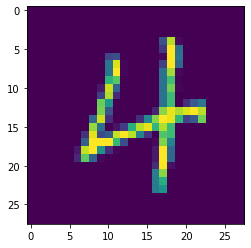

The neural net guesses:
9


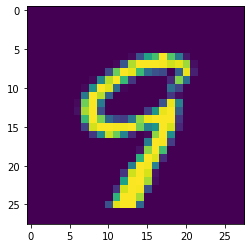

The neural net guesses:
2


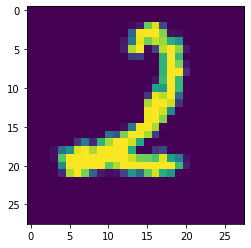

The neural net guesses:
1


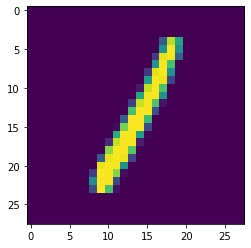

The neural net guesses:
6


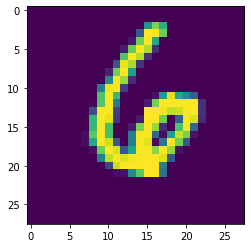

The neural net guesses:
2


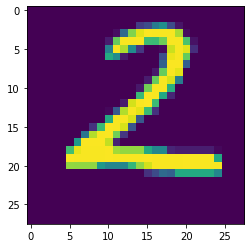

The neural net guesses:
1


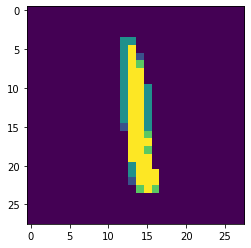

The neural net guesses:
8


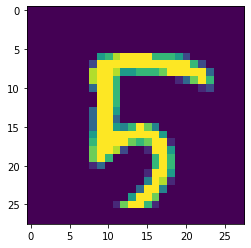

The neural net guesses:
7


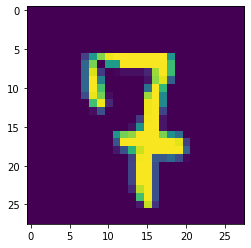

The neural net guesses:
1


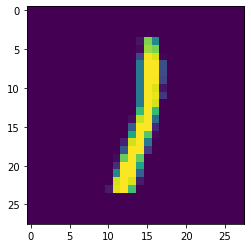

The neural net guesses:
9


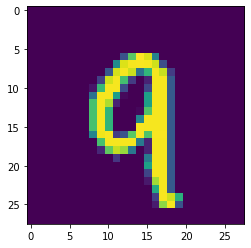

The neural net guesses:
7


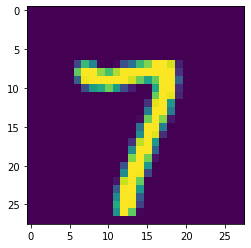

The neural net guesses:
0


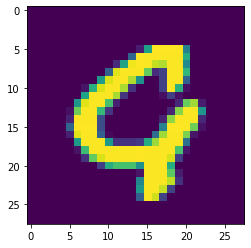

The neural net guesses:
2


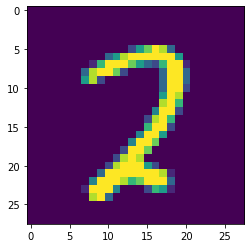

The neural net guesses:
2


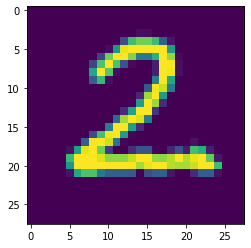

The neural net guesses:
8


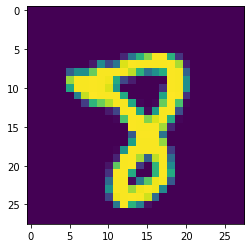

The neural net guesses:
1


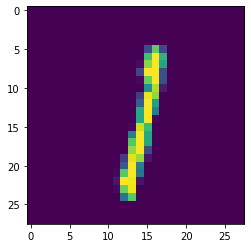

The neural net guesses:
7


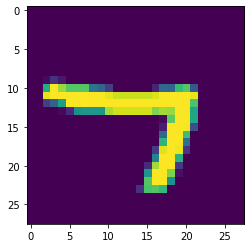

The neural net guesses:
7


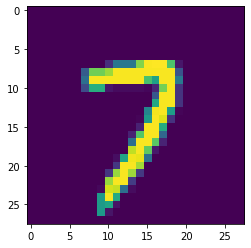

The neural net guesses:
0


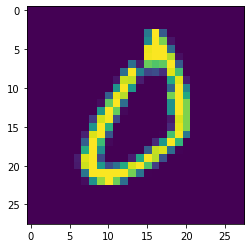

The neural net guesses:
0


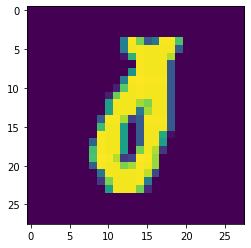

The neural net guesses:
1


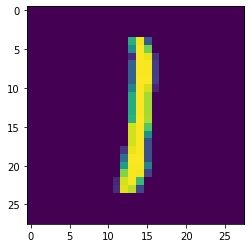

The neural net guesses:
8


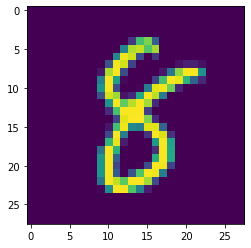

The neural net guesses:
0


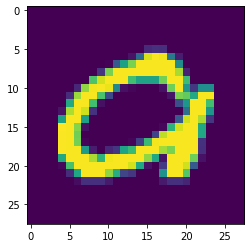

The neural net guesses:
0


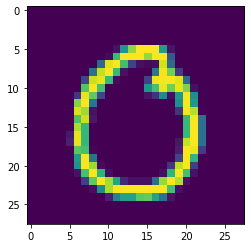

The neural net guesses:
6


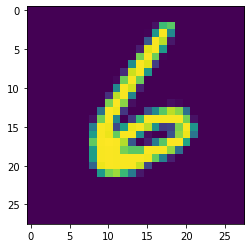

The neural net guesses:
6


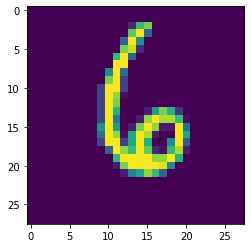

The neural net guesses:
4


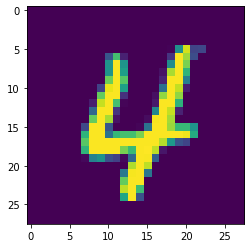

The neural net guesses:
7


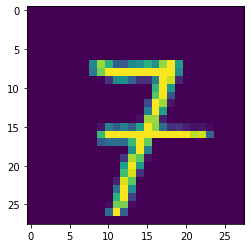

The neural net guesses:
9


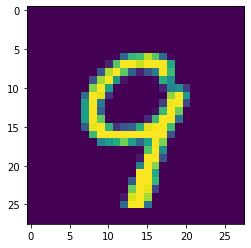

The neural net guesses:
3


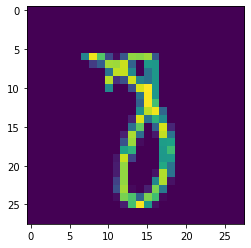

The neural net guesses:
2


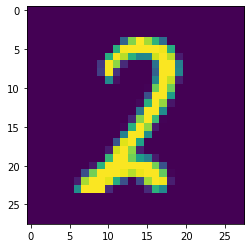

The neural net guesses:
7


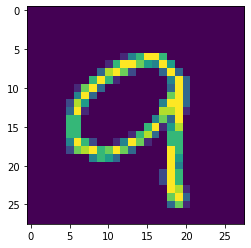

The neural net guesses:
1


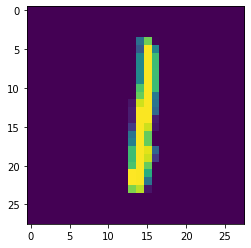

The neural net guesses:
5


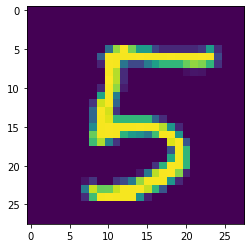

The neural net guesses:
2


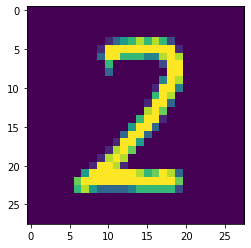

The neural net guesses:
5


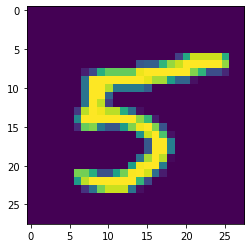

The neural net guesses:
3


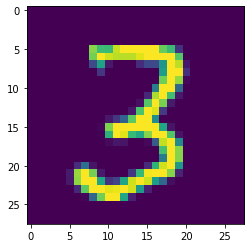

The neural net guesses:
7


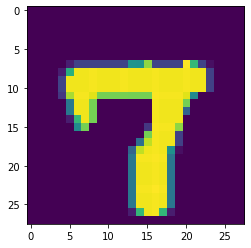

The neural net guesses:
7


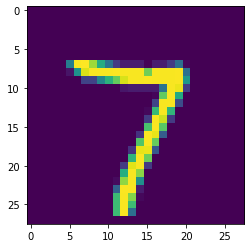

The neural net guesses:
0


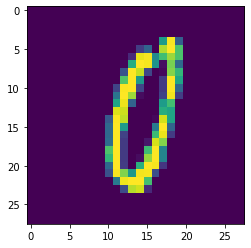

The neural net guesses:
0


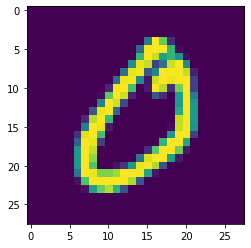

The neural net guesses:
6


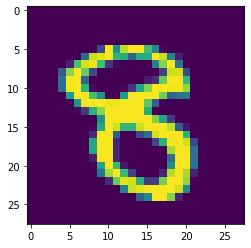

The neural net guesses:
2


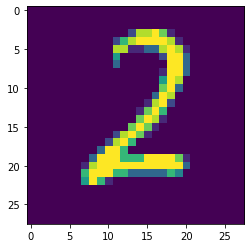

The neural net guesses:
3


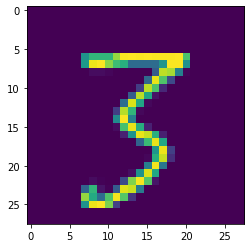

The neural net guesses:
1


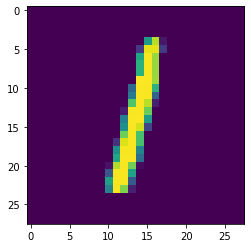

The neural net guesses:
3


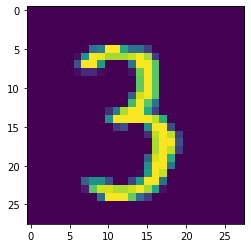

The neural net guesses:
5


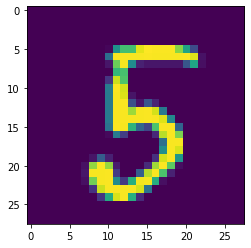

The neural net guesses:
1


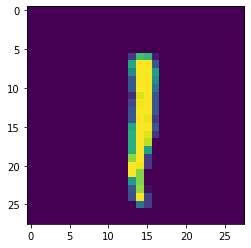

The neural net guesses:
3


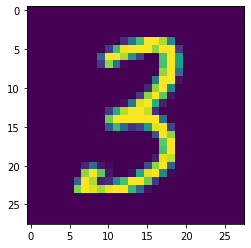

The neural net guesses:
6


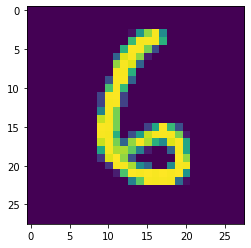

The neural net guesses:
4


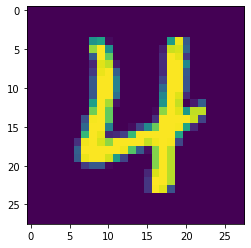

The neural net guesses:
8


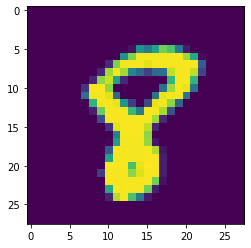

The neural net guesses:
7


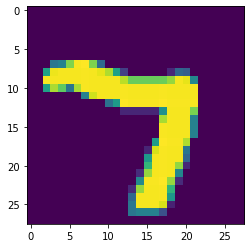

The neural net guesses:
6


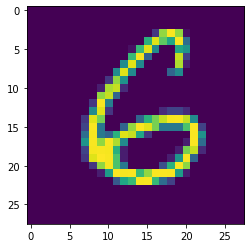

The neural net guesses:
2


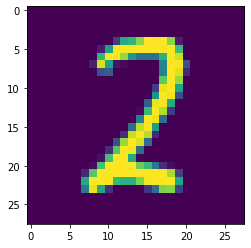

The neural net guesses:
8


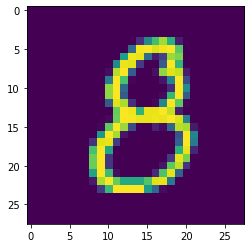

The neural net guesses:
1


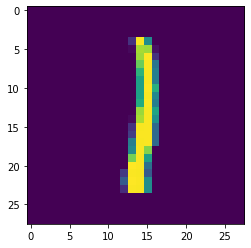

The neural net guesses:
3


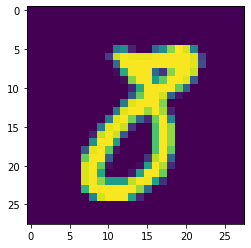

The neural net guesses:
6


KeyboardInterrupt: 

In [22]:
testOn = 100

accuracy = 0

for number, answer in validation_data:
    guess, l = NN.Run(number, expected=answer)
    
    print("The neural net guesses:\n%i"%np.argmax(guess, axis=0)[0])
    plt.imshow(number.reshape(28, 28))
    plt.show()
    
    if answer == np.argmax(guess, axis=0)[0]:
        accuracy += 1
    

print("===========================")
print("CRAPNet was right %1.1f%% of the time!" %(accuracy/len(validation_data) * 100))